# Affine transform
In this notebook, we check whether data coming from two different sites, but having the same class, could be transformed into each other using affine transforms.

In [1]:
from Data.Dataset import LatentFMRIDataset
import matplotlib.pyplot as plt
%matplotlib inline
from einops import rearrange
import numpy as np
from sklearn.covariance import empirical_covariance
from scipy.linalg import sqrtm
from scipy.stats import ortho_group

In [2]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

# Dataset

In [3]:
nyu_data_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/NYU_all'
um1_data_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/UM_1_all'
nyu_dataset = LatentFMRIDataset(data_dir=nyu_data_directory)
um1_dataset = LatentFMRIDataset(data_dir=um1_data_directory)

In [4]:
nyu_1 = nyu_dataset.get_items_from_class(cls=1)['X']
nyu_2 = nyu_dataset.get_items_from_class(cls=2)['X']
um1_1 = um1_dataset.get_items_from_class(cls=1)['X']
um1_2 = um1_dataset.get_items_from_class(cls=2)['X']

nyu_1.shape, um1_1.shape, nyu_2.shape, um1_2.shape

((12600, 4, 16, 18),
 (10030, 4, 16, 18),
 (16975, 4, 16, 18),
 (13570, 4, 16, 18))

In [5]:
nyu_1 = rearrange(nyu_1, 'a b c d -> a (b c d)')
nyu_2 = rearrange(nyu_2, 'a b c d -> a (b c d)')
um1_1 = rearrange(um1_1, 'a b c d -> a (b c d)')
um1_2 = rearrange(um1_2, 'a b c d -> a (b c d)')

nyu_1.shape, um1_1.shape, nyu_2.shape, um1_2.shape

((12600, 1152), (10030, 1152), (16975, 1152), (13570, 1152))

# Empirical Covariance calculation

When the number of features is fixed and does not depend on the index of the sample, the empirical covariance matrix is a good estimator (https://math.mit.edu/~liewang/ECM.pdf)

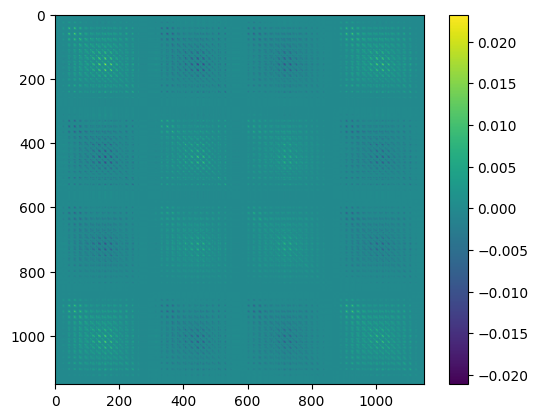

In [6]:
emprical_cov_mtx = empirical_covariance(nyu_1, assume_centered=False)
plt.imshow(emprical_cov_mtx)
plt.colorbar()

In [7]:
for site in [um1_1, um1_2, nyu_1, nyu_2]:
    print(is_pos_def(empirical_covariance(site, assume_centered=False)))

True
True
True
True


# Calculate the A matrix and b translation of the affine transform

In [8]:
c = empirical_covariance(nyu_1)
c_aff = empirical_covariance(um1_1)

c_r = sqrtm(c)
c_aff_r = sqrtm(c_aff)

mean_1_aff = np.mean(um1_1, axis=0)
mean_1 = np.mean(nyu_1, axis=0)

Q = ortho_group.rvs(dim=c_r.shape[0]) # any orthogonal mtx is ok

A_rec = c_aff_r @ Q @ np.linalg.inv(c_r)
b_rec = mean_1_aff - A_rec.dot(mean_1)
b_rec = np.expand_dims(b_rec, axis=-1)
# A_rec_inv = np.linalg.inv(A_rec)

z_original_inverse_1 = A_rec.dot(nyu_1.transpose()) + b_rec
z_original_inverse_1.shape

(1152, 12600)

In [9]:
z_original_inverse_1.mean(), nyu_1.mean(), um1_1.mean()

(0.49302847383915877, 0.43671605799872365, 0.4930284738515166)

# z_original mean és covar és összehas az um1-el

### Covariance comparison

In [10]:
original_cov = empirical_covariance(nyu_1)
rec_cov = empirical_covariance(z_original_inverse_1.T)
random_cov = empirical_covariance(np.random.normal(size=(12600, 1152)))

print(np.sum(np.sqrt((original_cov - rec_cov)**2)))
print(np.sum(np.sqrt((original_cov - random_cov)**2)))

3100.090275070325
10662.782724490133


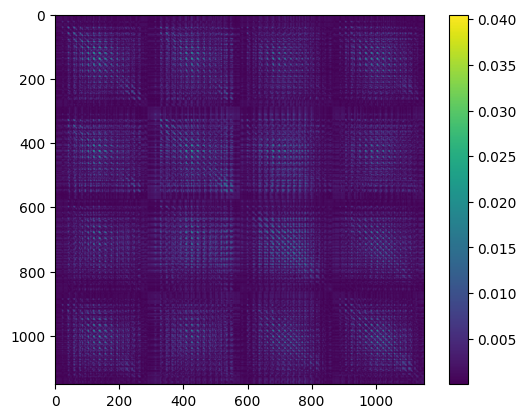

In [11]:
plt.imshow(np.sqrt((original_cov - rec_cov)**2))
plt.colorbar()
plt.show()

### Mean comparison

In [12]:
diff = np.mean(nyu_1, axis=0) - np.mean(z_original_inverse_1.T, axis=0)
diff_rand = np.mean(nyu_1, axis=0) - np.mean(np.random.normal((12600, 1152)), axis=0)
diff_sites = np.mean(nyu_1, axis=0) - np.mean(um1_1, axis=0)
np.sum(np.sqrt(diff**2)), np.sum(np.sqrt(diff_rand**2)), np.sum(np.sqrt(diff_sites**2))

(76.0453715253449, 7919878.71287368, 76.04537153064166)

1. A mtx meg b-vel a másik osztályt is eltolni, megnézni a covart és meant (itt is lineáris?): ugyanaz a trafó müxik? Vagy kell e másik A és b a másik osztályokra?

In [13]:
z_original_inverse_2 = A_rec.dot(nyu_2.transpose()) + b_rec
z_original_inverse_2.shape

(1152, 16975)

In [14]:
z_original_inverse_2.mean(), nyu_2.mean(), um1_2.mean()

(0.6420425229058822, 0.4363250033047024, 0.49105900261150376)

In [15]:
original_cov = empirical_covariance(nyu_2)
rec_cov = empirical_covariance(z_original_inverse_2.T)
random_cov = empirical_covariance(np.random.normal(size=(16975, 1152)))

print(np.sum(np.sqrt((original_cov - rec_cov)**2)))
print(np.sum(np.sqrt((original_cov - random_cov)**2)))

5848802.742965133
9357.13073652778


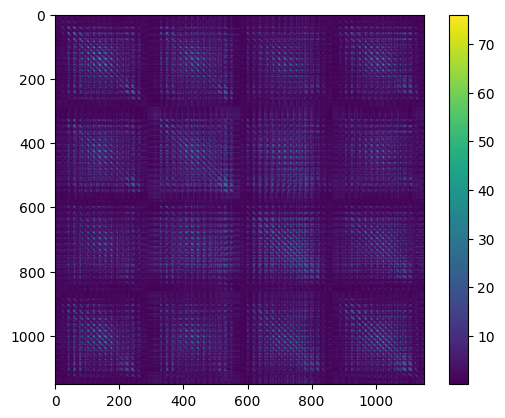

In [16]:
plt.imshow(np.sqrt((original_cov - rec_cov)**2))
plt.colorbar()
plt.show()

In [17]:
diff = np.mean(nyu_2, axis=0) - np.mean(z_original_inverse_2.T, axis=0)
diff_rand = np.mean(nyu_2, axis=0) - np.mean(np.random.normal((16975, 1152)), axis=0)
diff_sites = np.mean(nyu_2, axis=0) - np.mean(um1_2, axis=0)
np.sum(np.sqrt(diff**2)), np.sum(np.sqrt(diff_rand**2)), np.sum(np.sqrt(diff_sites**2))

(409.2274757135482, 10441345.17532694, 75.75062080500302)

2. Cross classification (nyu eltoltján tanítok, um1-en tesztelek)

In [18]:
from SVM_Experiments import SVMAffine

In [19]:
experiment = SVMAffine(train_dir=nyu_data_directory,
                       test_dir=um1_data_directory,
                       train_site_name='NYU',
                       test_site_name='UM1',
                       c_values=[10.0],
                       A1=A_rec,
                       b1=b_rec,
                       A2=A_rec,
                       b2=b_rec)

(29575, 1152) (29575,) (23600, 1152) (23600,)


In [ ]:
experiment.perform_experiment()

[LibSVM]..

In [19]:
# nyu2 -> um2 transform

c = empirical_covariance(nyu_2)
c_aff = empirical_covariance(um1_2)

c_r = sqrtm(c)
c_aff_r = sqrtm(c_aff)

mean_1_aff = np.mean(um1_2, axis=0)
mean_1 = np.mean(nyu_2, axis=0)

Q = ortho_group.rvs(dim=c_r.shape[0]) # any orthogonal mtx is ok

A_rec_2 = c_aff_r @ Q @ np.linalg.inv(c_r)
b_rec_2 = mean_1_aff - A_rec_2.dot(mean_1)
b_rec_2 = np.expand_dims(b_rec_2, axis=-1)
# A_rec_inv = np.linalg.inv(A_rec_2)

z_original_inverse_2 = A_rec_2.dot(nyu_2.transpose()) + b_rec_2
z_original_inverse_2.shape

(1152, 16975)

In [20]:
original_cov = empirical_covariance(nyu_2)
rec_cov = empirical_covariance(z_original_inverse_2.T)
random_cov = empirical_covariance(np.random.normal(size=(16975, 1152)))

print(np.sum(np.sqrt((original_cov - rec_cov)**2)))
print(np.sum(np.sqrt((original_cov - random_cov)**2)))

1910.5718515210165
9346.015735004108


In [21]:
diff = np.mean(nyu_2, axis=0) - np.mean(z_original_inverse_2.T, axis=0)
diff_rand = np.mean(nyu_2, axis=0) - np.mean(np.random.normal((16975, 1152)), axis=0)
diff_sites = np.mean(nyu_2, axis=0) - np.mean(um1_2, axis=0)
np.sum(np.sqrt(diff**2)), np.sum(np.sqrt(diff_rand**2)), np.sum(np.sqrt(diff_sites**2))

(75.7506208055849, 10440138.73908379, 75.75062080500302)

In [ ]:
experiment = SVMAffine(train_dir=nyu_data_directory,
                       test_dir=um1_data_directory,
                       train_site_name='NYU',
                       test_site_name='UM1',
                       c_values=[10.0],
                       A1=A_rec_2,
                       b1=b_rec_2,
                       A2=A_rec_2,
                       b2=b_rec_2)

In [ ]:
experiment.perform_experiment()

In [22]:
experiment = SVMAffine(train_dir=nyu_data_directory,
                       test_dir=um1_data_directory,
                       train_site_name='NYU',
                       test_site_name='UM1',
                       c_values=[10.0],
                       A1=A_rec,
                       b1=b_rec,
                       A2=A_rec_2,
                       b2=b_rec_2)

(29575, 1152) (29575,) (23600, 1152) (23600,)


[LibSVM]..........................................................*.................*
optimization finished, #iter = 75065
obj = -255703.779436, rho = 0.225118
nSV = 27972, nBSV = 19597
Total nSV = 27972


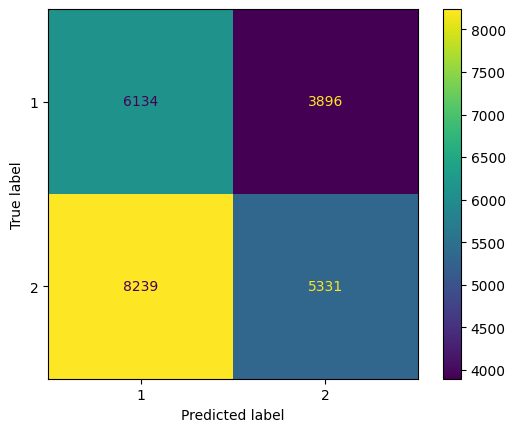

In [23]:
experiment.perform_experiment()